In [1]:
import os
import sys
from optparse import OptionParser

import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML

%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables 
import pickle
import warnings
from sklearn.externals import joblib
warnings.filterwarnings('once')

In [2]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/bg-3-'

In [3]:
# ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model(dist,E): # E: log10 of energy!!! 

    a = params[0] + params[2] * (E + params[1])**2
    b = params[3] + params[5] * (E + params[4])**2
    val = 10 * a / dist**(1/3.) * np.exp( -10**6 * b / dist**2)
    
    val[val < 0.001] = 0.001 # This is arbitrary! 

    # low stat cut 
    val[E > 5.4+1.9*np.sqrt(1 - (dist)**2/2300**2)]=0.7
    val[dist>2200]=0.7
    return val

In [4]:
IT_ineff_cut = 0.01
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4

    CUT = CUT_ineff & CUT_dedx # & CUT_untag
    
    chi2_red_data_burn =f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    print(np.sum(weight_data_burn))
    
    run_id_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    event_id_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

186798.0552404548


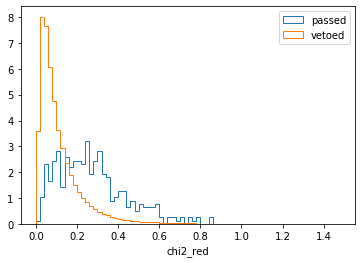

In [5]:
plt.hist(chi2_red_data_burn[passed_2_data_burn],bins=np.arange(0,1.5,0.02),histtype='step',density=True,label='passed')
plt.hist(chi2_red_data_burn[vetoed_2_data_burn],bins=np.arange(0,1.5,0.02),histtype='step',density=True,label='vetoed')
plt.xlabel('chi2_red')
plt.legend()
plt.show()

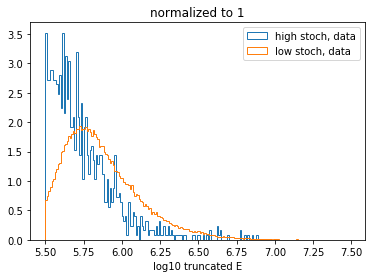

In [6]:
chi2_red_cut = 0.3
pom_cut = 0.8

cut_high_stoch = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut)
cut_low_stoch = np.any([chi2_red_data_burn < chi2_red_cut,np.log10(PeakOverMedian_data_burn) < pom_cut],axis=0)

plt.hist(np.log10(truncated_muon_e_data_burn)[cut_high_stoch],bins=np.arange(5.5,7.5,0.01),density=True,histtype='step',label='high stoch, data')
plt.hist(np.log10(truncated_muon_e_data_burn)[cut_low_stoch],bins=np.arange(5.5,7.5,0.01),density=True,histtype='step',label='low stoch, data')

plt.xlabel('log10 truncated E')
plt.legend()
plt.title('normalized to 1')
plt.savefig(fig_dir + 'hist1d_truncated_for_each_stoch_region.png',dpi=300,bbox_inches='tight')
plt.show()

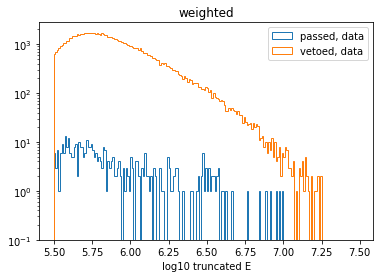

In [7]:
cut_passed = passed_2_data_burn
cut_vetoed = vetoed_2_data_burn

plt.hist(np.log10(truncated_muon_e_data_burn)[cut_passed],bins=np.arange(5.5,7.5,0.01),log=True,histtype='step',label='passed, data')
plt.hist(np.log10(truncated_muon_e_data_burn)[cut_vetoed],bins=np.arange(5.5,7.5,0.01),log=True,histtype='step',label='vetoed, data')

plt.xlabel('log10 truncated E')
plt.legend()
plt.title('weighted')
plt.savefig(fig_dir + 'hist1d_truncated_for_each_stoch_region.png',dpi=300,bbox_inches='tight')

plt.show()

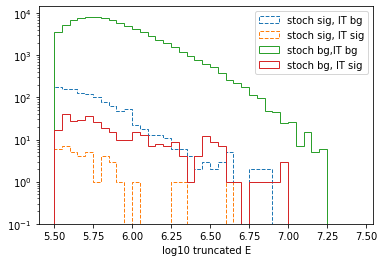

In [8]:
CUT_stoch_sig_IT_sig = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & passed_2_data_burn  
CUT_stoch_sig_IT_bg = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & vetoed_2_data_burn  
CUT_stoch_bg_IT_sig = np.any([chi2_red_data_burn < chi2_red_cut, np.log10(PeakOverMedian_data_burn) < pom_cut],axis=0) & passed_2_data_burn  
CUT_stoch_bg_IT_bg = np.any([chi2_red_data_burn < chi2_red_cut, np.log10(PeakOverMedian_data_burn) < pom_cut],axis=0) & vetoed_2_data_burn  

plt.hist(np.log10(truncated_muon_e_data_burn)[CUT_stoch_sig_IT_bg],bins=np.arange(5.5,7.5,0.05),linestyle='dashed',log=True,histtype='step',label='stoch sig, IT bg')
plt.hist(np.log10(truncated_muon_e_data_burn)[CUT_stoch_sig_IT_sig],bins=np.arange(5.5,7.5,0.05),linestyle='dashed',log=True,histtype='step',label='stoch sig, IT sig')
plt.hist(np.log10(truncated_muon_e_data_burn)[CUT_stoch_bg_IT_bg],bins=np.arange(5.5,7.5,0.05),log=True,histtype='step',label='stoch bg,IT bg')
plt.hist(np.log10(truncated_muon_e_data_burn)[CUT_stoch_bg_IT_sig],bins=np.arange(5.5,7.5,0.05),log=True,histtype='step',label='stoch bg, IT sig')
plt.xlabel('log10 truncated E')

plt.legend()
plt.show()

# 1. 2x2 Panel in Different Energy Bins

In [9]:
def err_ratio(x,y,x_err,y_err): # a/b
    return x/y*np.sqrt(  (x_err/x)**2 + (y_err/y)**2  )

PV_ratio = []
PV_ratio_err = []
E = []

energy_regions = np.arange(5.5,7.5,0.3)
for i in range(0,len(energy_regions)-1):
    cut_energy = (np.log10(truncated_muon_e_data_burn)>energy_regions[i]) & (np.log10(truncated_muon_e_data_burn)<=energy_regions[i+1])
    
#     CUT_stoch_sig_IT_sig = (chi2_red_data_burn[cut_energy] > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn)[cut_energy] > pom_cut) & passed_2_data_burn[cut_energy]  
#     CUT_stoch_sig_IT_bg = (chi2_red_data_burn[cut_energy] > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn)[cut_energy] > pom_cut) & vetoed_2_data_burn[cut_energy]  
#     CUT_stoch_bg_IT_sig = np.any([chi2_red_data_burn[cut_energy] < chi2_red_cut, np.log10(PeakOverMedian_data_burn)[cut_energy] < pom_cut],axis=0) & passed_2_data_burn[cut_energy]  
#     CUT_stoch_bg_IT_bg = np.any([chi2_red_data_burn[cut_energy] < chi2_red_cut, np.log10(PeakOverMedian_data_burn)[cut_energy] < pom_cut],axis=0) & vetoed_2_data_burn[cut_energy]  
    
#     d11 = np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_bg])
#     d12 = np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_sig])
#     d21 = np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg])
#     d22 = np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_sig])
#     total = np.sum(weight_data_burn[cut_energy]) # now, sum of 4 panels is NOT total events in phase space. 
    
#     d11_len, d12_len, d21_len, d22_len = len(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg]),len(weight_data_burn[cut_energy][CUT_stoch_sig_IT_sig]),len(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg]),len(weight_data_burn[cut_energy][CUT_stoch_bg_IT_sig])
    
#     d11_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_bg]**2))
#     d12_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_sig]**2))
#     d21_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg]**2))
#     d22_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_sig]**2))
    
    CUT_IT_sig = passed_2_data_burn[cut_energy]
    CUT_IT_bg = vetoed_2_data_burn[cut_energy]
    
    d_sig = np.sum(weight_data_burn[cut_energy][CUT_IT_sig])
    d_bg = np.sum(weight_data_burn[cut_energy][CUT_IT_bg])

    d_sig_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_IT_sig]**2))
    d_bg_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_IT_bg]**2))
    
    E=np.append(E, (energy_regions[i]+energy_regions[i+1])/2)
    print(energy_regions[i],d_sig,d_bg)
    PV_ratio=np.append(PV_ratio, d_sig/d_bg)
    PV_ratio_err=np.append(PV_ratio_err, err_ratio(d_sig,d_bg,d_sig_err,d_bg_err))
    

5.5 425.6351762533177 84573.29628349905
5.8 188.02330601481512 69355.80563735493
6.1 78.5152266875052 22573.12767265775
6.3999999999999995 72.31665615954428 5739.8763088918295
6.699999999999999 14.46333123190886 1041.3598486974377
6.999999999999999 0.0 121.9052203832318


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


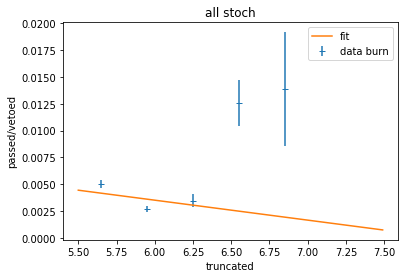

In [10]:
E = E[PV_ratio>0]
PV_ratio_err = PV_ratio_err[PV_ratio>0]
PV_ratio = PV_ratio[PV_ratio>0]

plt.errorbar(E,PV_ratio,yerr=PV_ratio_err,fmt='_',label='data burn')

def f(x,a,b):
    return a*x + b
popt,pcov = curve_fit(f,E,PV_ratio,sigma=PV_ratio_err)

t = np.arange(5.5,7.5,0.01)
plt.plot(t,f(t,*popt),label='fit')

plt.xlabel('truncated')
plt.ylabel('passed/vetoed')
plt.title('all stoch')
plt.legend()
plt.show()

In [11]:
CUT_stoch_sig_IT_sig = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & passed_2_data_burn  
CUT_stoch_sig_IT_bg = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & vetoed_2_data_burn  
CUT_stoch_bg_IT_sig = np.any([chi2_red_data_burn < chi2_red_cut, np.log10(PeakOverMedian_data_burn) < pom_cut],axis=0) & passed_2_data_burn  
CUT_stoch_bg_IT_bg = np.any([chi2_red_data_burn < chi2_red_cut, np.log10(PeakOverMedian_data_burn) < pom_cut],axis=0) & vetoed_2_data_burn  

d11 = weight_data_burn[CUT_stoch_sig_IT_bg]
d12 = weight_data_burn[CUT_stoch_sig_IT_sig]
d21 = weight_data_burn[CUT_stoch_bg_IT_bg]
d22 = weight_data_burn[CUT_stoch_bg_IT_sig]

truncated_d11 = truncated_muon_e_data_burn[CUT_stoch_sig_IT_bg]
truncated_d21 = truncated_muon_e_data_burn[CUT_stoch_bg_IT_bg]

df_events = pd.DataFrame({"N events": ["High Stoch", "Low Stoch"],
                   "IT vetoed": [np.sum(d11), np.sum(d21)], 
                   "IT passed": [np.sum(d12), np.sum(d22)]})
print(df_events)
print('\n')
print('total bg in signal region', np.sum(f(np.log10(truncated_d11),*popt) * d11) )
print('new passed/vetoed in high stoch region', np.sum(f(np.log10(truncated_d11),*popt) * d11)/np.sum(d11))
print('new passed/vetoed in low stoch region',np.sum(f(np.log10(truncated_d21),*popt) * d21)/np.sum(d21))
print('\n')
print('old passed/vetoed in high stoch region',np.sum(d12)/np.sum(d11))
print('old passed/vetoed in low stoch region',np.sum(d22)/np.sum(d21))


     N events      IT vetoed   IT passed
0  High Stoch    2700.510560   97.110938
1   Low Stoch  183293.796702  706.637040


total bg in signal region 10.873205690373508
new passed/vetoed in high stoch region 0.004026351850412014
new passed/vetoed in low stoch region 0.0037617949224694317


old passed/vetoed in high stoch region 0.0359602142310635
old passed/vetoed in low stoch region 0.0038552152495180993


In [12]:
#### same plot for different stochasticity distribution

In [13]:
def err_ratio(x,y,x_err,y_err): # a/b
    return x/y*np.sqrt(  (x_err/x)**2 + (y_err/y)**2  )

PV_ratio_high_stoch = []
PV_ratio_err_high_stoch = []
PV_ratio_low_stoch = []
PV_ratio_err_low_stoch = []
E = []

energy_regions = np.arange(5.5,7.5,0.3)
for i in range(0,len(energy_regions)-1):
    cut_energy = (np.log10(truncated_muon_e_data_burn)>energy_regions[i]) & (np.log10(truncated_muon_e_data_burn)<=energy_regions[i+1])
    
    CUT_stoch_sig_IT_sig = (chi2_red_data_burn[cut_energy] > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn)[cut_energy] > pom_cut) & passed_2_data_burn[cut_energy]  
    CUT_stoch_sig_IT_bg = (chi2_red_data_burn[cut_energy] > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn)[cut_energy] > pom_cut) & vetoed_2_data_burn[cut_energy]  
    CUT_stoch_bg_IT_sig = np.any([chi2_red_data_burn[cut_energy] < chi2_red_cut, np.log10(PeakOverMedian_data_burn)[cut_energy] < pom_cut],axis=0) & passed_2_data_burn[cut_energy]  
    CUT_stoch_bg_IT_bg = np.any([chi2_red_data_burn[cut_energy] < chi2_red_cut, np.log10(PeakOverMedian_data_burn)[cut_energy] < pom_cut],axis=0) & vetoed_2_data_burn[cut_energy]  
    
    d11 = np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_bg])
    d12 = np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_sig])
    d21 = np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg])
    d22 = np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_sig])
    total = np.sum(weight_data_burn[cut_energy]) # now, sum of 4 panels is NOT total events in phase space. 
    
    d11_len, d12_len, d21_len, d22_len = len(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg]),len(weight_data_burn[cut_energy][CUT_stoch_sig_IT_sig]),len(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg]),len(weight_data_burn[cut_energy][CUT_stoch_bg_IT_sig])
    
    d11_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_bg]**2))
    d12_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_sig]**2))
    d21_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg]**2))
    d22_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_sig]**2))
    
    E=np.append(E, (energy_regions[i]+energy_regions[i+1])/2)

    PV_ratio_high_stoch=np.append(PV_ratio_high_stoch, d12/d11)
    PV_ratio_err_high_stoch=np.append(PV_ratio_err_high_stoch, err_ratio(d12,d11,d12_err,d11_err))
    
    PV_ratio_low_stoch=np.append(PV_ratio_low_stoch, d22/d21)
    PV_ratio_err_low_stoch=np.append(PV_ratio_err_low_stoch, err_ratio(d22,d21,d22_err,d21_err))
    

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


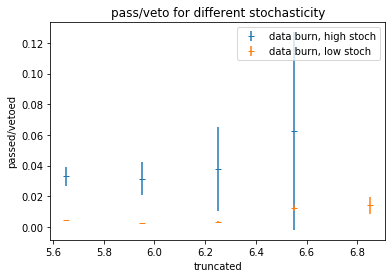

In [14]:
E_high = E[PV_ratio_high_stoch>0]
PV_ratio_err_high_stoch = PV_ratio_err_high_stoch[PV_ratio_high_stoch>0]
PV_ratio_high_stoch = PV_ratio_high_stoch[PV_ratio_high_stoch>0]

E_low = E[PV_ratio_low_stoch>0]
PV_ratio_err_low_stoch = PV_ratio_err_low_stoch[PV_ratio_low_stoch>0]
PV_ratio_low_stoch = PV_ratio_low_stoch[PV_ratio_low_stoch>0]

plt.errorbar(E_high,PV_ratio_high_stoch,yerr=PV_ratio_err_high_stoch,fmt='_',label='data burn, high stoch')
plt.errorbar(E_low,PV_ratio_low_stoch,yerr=PV_ratio_err_low_stoch,fmt='_',label='data burn, low stoch')

# def f(x,a,b):
#     return a*x + b
# popt,pcov = curve_fit(f,E_high,PV_ratio_high_stoch,sigma=PV_ratio_err_high_stoch)

# t = np.arange(5.5,7.5,0.01)
# plt.plot(t,f(t,*popt),label='fit')

plt.xlabel('truncated')
plt.ylabel('passed/vetoed')
plt.title('pass/veto for different stochasticity')
plt.legend()
plt.show()

# 2. Likelihood-Based Method

<font size = 3>
Suppose the IceTop tags for data are $y_i$ = 1 if passed veto, $y_i=0$ otherwise. Let the passing probability $R=\frac{pass}{pass+veto}$ be paramatrized by 
    $$R(E)=a + b\cdot \log_{10}\frac{E}{1PeV}$$ 
Then the probability of observing the data is <br/>
    $$L = \prod_i^N R(E_i)^{y_i}(1-R(E_i))^{1-y_i}$$
Maximizing the likelihood is equivalent to minimizing: <br/>
    $$-lnL = \sum_i^N -y_i \ln(R(E_i))-(1-y_i)\ln(1-R(E_i))   $$

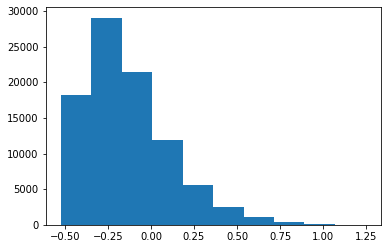

In [15]:
plt.hist(np.log10(truncated_muon_e_data_burn/10**6))
plt.show()

In [16]:
IT_tag = passed_2_data_burn.astype(float)
def R(param): # currently R == passed/(passed+vetoed) {= 0 if vetoed, = 1 if passed}
    return param[0] + param[1]*np.log10(truncated_muon_e_data_burn/10**6)

def lnL(param):
    tmp = - IT_tag*np.log(R(param)) - (1-IT_tag)*np.log(1-R(param))
    return np.sum(tmp)

# def consR(param):
#     return 1- (param[0] + param[1]*np.log10(truncated_muon_e_data_burn/10**6))

opt = ci.optimize.minimize(lnL,x0=[0.5,-0.1],constraints = ({'type': 'ineq', 'fun': R}))

# # opt = ci.optimize.minimize(lnL,x0=[0.25,-0.1],
# #                constraints = ({'type': 'ineq', 'fun': R},{'type': 'ineq', 'fun': consR}))
print(opt)
popt = opt.x

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


     fun: 2507.562494084415
     jac: array([ 0.08059692, -0.0206604 ])
 message: 'Optimization terminated successfully.'
    nfev: 246
     nit: 50
    njev: 50
  status: 0
 success: True
       x: array([0.00433617, 0.00024417])


In [17]:
# likelihood scan
aa = np.arange(0.001,0.01,0.0001)
bb = np.arange(-0.001,0.001,0.0001)
a, b = np.meshgrid(aa,bb)[0].ravel(),np.meshgrid(aa,bb)[1].ravel()
llh = []
for i in range(0,len(a)):
    llh.append(lnL([a[i],b[i]]))

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


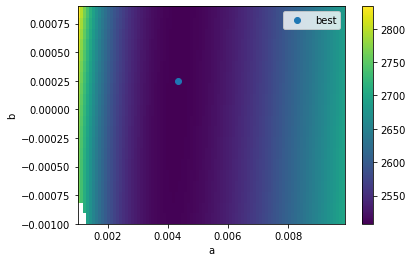

In [18]:
plt.hist2d(a,b,weights=llh,bins=[len(aa),len(bb)])
plt.plot(popt[0],popt[1],'o',label='best')
plt.xlabel('a')
plt.ylabel('b')
plt.colorbar()
plt.legend()
plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


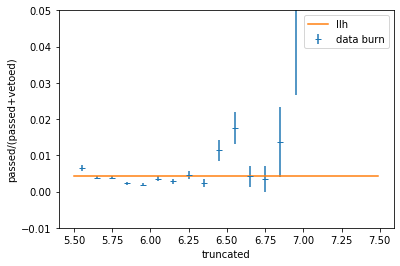

In [19]:
def err_1_divide_2(x,y,z,x_err,y_err,z_err): # a/(b+c)
    return 1/(y+z) * np.sqrt(x_err**2 + (x/(y+z))**2*(y_err**2+z_err**2))

Pass_ratio = []
Pass_ratio_err = []
E = []

energy_regions = np.arange(5.5,7.5,0.1)
for i in range(0,len(energy_regions)-1):
    cut_energy = (np.log10(truncated_muon_e_data_burn)>energy_regions[i]) & (np.log10(truncated_muon_e_data_burn)<=energy_regions[i+1])
    
    CUT_stoch_sig_IT_sig = (chi2_red_data_burn[cut_energy] > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn)[cut_energy] > pom_cut) & passed_2_data_burn[cut_energy]  
    CUT_stoch_sig_IT_bg = (chi2_red_data_burn[cut_energy] > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn)[cut_energy] > pom_cut) & vetoed_2_data_burn[cut_energy]  
    CUT_stoch_bg_IT_sig = np.any([chi2_red_data_burn[cut_energy] < chi2_red_cut, np.log10(PeakOverMedian_data_burn)[cut_energy] < pom_cut],axis=0) & passed_2_data_burn[cut_energy]  
    CUT_stoch_bg_IT_bg = np.any([chi2_red_data_burn[cut_energy] < chi2_red_cut, np.log10(PeakOverMedian_data_burn)[cut_energy] < pom_cut],axis=0) & vetoed_2_data_burn[cut_energy]  

    d11 = np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_bg])
    d12 = np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_sig])
    d21 = np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg])
    d22 = np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_sig])
    total = np.sum(weight_data_burn[cut_energy]) # now, sum of 4 panels is NOT total events in phase space. 

    d11_len, d12_len, d21_len, d22_len = len(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg]),len(weight_data_burn[cut_energy][CUT_stoch_sig_IT_sig]),len(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg]),len(weight_data_burn[cut_energy][CUT_stoch_bg_IT_sig])

    d11_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_bg]**2))
    d12_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_sig_IT_sig]**2))
    d21_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_bg]**2))
    d22_err = np.sqrt(np.sum(weight_data_burn[cut_energy][CUT_stoch_bg_IT_sig]**2))
    
    E=np.append(E, (energy_regions[i]+energy_regions[i+1])/2 )
    Pass_ratio=np.append(Pass_ratio, d22/(d22+d21))
    Pass_ratio_err=np.append(Pass_ratio_err, err_1_divide_2(d22,d22,d21,d22_err,d22_err,d21_err)) # need change! 
    
    
E = E[Pass_ratio>0]
Pass_ratio_err = Pass_ratio_err[Pass_ratio>0]
Pass_ratio = Pass_ratio[Pass_ratio>0]

plt.errorbar(E,Pass_ratio,yerr=Pass_ratio_err,fmt='_',label='data burn')

def f(x,a,b):
    return a + b*x/10**6

t = np.arange(5.5,7.5,0.01)
plt.plot(t,f(t,*popt),label='llh')

plt.xlabel('truncated')
plt.ylabel('passed/(passed+vetoed)')
plt.ylim(-0.01,0.05)
plt.legend()
plt.show()

In [20]:
CUT_stoch_sig_IT_sig = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & passed_2_data_burn  
CUT_stoch_sig_IT_bg = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & vetoed_2_data_burn  
CUT_stoch_bg_IT_sig = np.any([chi2_red_data_burn < chi2_red_cut, np.log10(PeakOverMedian_data_burn) < pom_cut],axis=0) & passed_2_data_burn  
CUT_stoch_bg_IT_bg = np.any([chi2_red_data_burn < chi2_red_cut, np.log10(PeakOverMedian_data_burn) < pom_cut],axis=0) & vetoed_2_data_burn  

d11 = weight_data_burn[CUT_stoch_sig_IT_bg]
d12 = weight_data_burn[CUT_stoch_sig_IT_sig]
d21 = weight_data_burn[CUT_stoch_bg_IT_bg]
d22 = weight_data_burn[CUT_stoch_bg_IT_sig]

truncated_d11 = np.log10(truncated_muon_e_data_burn[CUT_stoch_sig_IT_bg])
truncated_d12 = np.log10(truncated_muon_e_data_burn[CUT_stoch_sig_IT_sig])
truncated_d21 = np.log10(truncated_muon_e_data_burn[CUT_stoch_bg_IT_bg])
truncated_d22 = np.log10(truncated_muon_e_data_burn[CUT_stoch_bg_IT_sig])

df_events = pd.DataFrame({"N events": ["High Stoch", "Low Stoch"],
                   "IT vetoed": [np.sum(d11), np.sum(d21)],
                   "IT passed": [np.sum(d12), np.sum(d22)]})
print(df_events)
print('\n')
print('total bg in signal region', np.sum(f(truncated_d11,*popt) * d11) + np.sum(f(truncated_d12,*popt) * d12) )
print('new passed/(passed+vetoed) in high stoch region', (np.sum(f(truncated_d11,*popt) * d11) + np.sum(f(truncated_d12,*popt) * d12))/(np.sum(d11)+np.sum(d12)) )
print('new passed/(passed+vetoed) in low stoch region', (np.sum(f(truncated_d21,*popt) * d21) + np.sum(f(truncated_d22,*popt) * d22))/(np.sum(d21)+np.sum(d22))) 
print('\n')
print('old passed/(passed+vetoed) in high stoch region',np.sum(d12)/(np.sum(d11) + np.sum(d12) ))
print('old passed/(passed+vetoed) in high stoch region',np.sum(d22)/(np.sum(d21) + np.sum(d22)))


     N events      IT vetoed   IT passed
0  High Stoch    2700.510560   97.110938
1   Low Stoch  183293.796702  706.637040


total bg in signal region 12.130957994253777
new passed/(passed+vetoed) in high stoch region 0.004336168420811881
new passed/(passed+vetoed) in low stoch region 0.004336168455737824


old passed/(passed+vetoed) in high stoch region 0.034711964549483006
old passed/(passed+vetoed) in high stoch region 0.0038404096436953287
